In [1]:
%load_ext autoreload
%autoreload 2

# ignore imputation warnings from pymc
# ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
import warnings
from pymc import ImputationWarning

warnings.filterwarnings("ignore", category=ImputationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [37]:
from birdcall_distribution.data import prepare_dataframe
import pandas as pd

taxonomy_df = pd.read_csv(
    "https://storage.googleapis.com/birdclef-eda-f22/data/raw/birdclef-2022/eBird_Taxonomy_v2021.csv"
)
taxonomy_df.columns = taxonomy_df.columns.str.lower()
species_mapper = taxonomy_df.set_index("species_code")["primary_com_name"].to_dict()

prep_df, W = prepare_dataframe(
    "../data/ee_v3_western_us_2.parquet",
    "../data/raw/birdclef-2022/train_metadata.csv",
    n_species=3,
)

<AxesSubplot:>

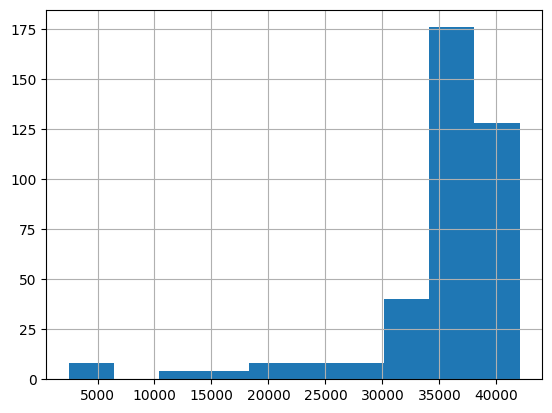

In [146]:
landcover_cols = [c for c in prep_df.columns if c.startswith("land_cover")]
prep_df[landcover_cols].sum(axis="columns")

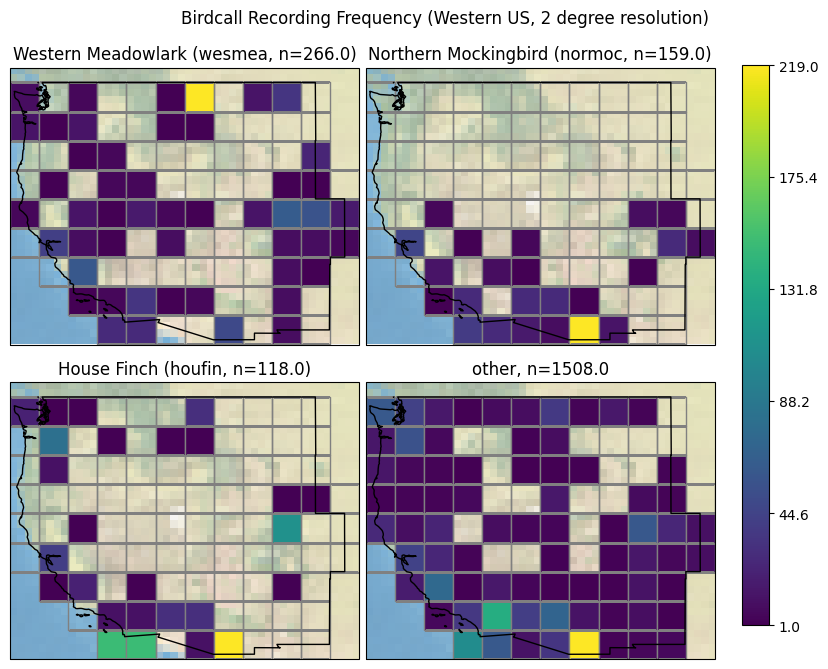

In [78]:
import matplotlib.pyplot as plt
from birdcall_distribution.plot import plot_species_subplot
import numpy as np

# grid size
grid_size = prep_df.grid_size.values[0]

# sorted list of records
species = list(
    prep_df[prep_df.primary_label != "other"]
    .groupby("primary_label")
    .sum(numeric_only=True)
    .y.sort_values(ascending=False)
    .index
)
plot_species_subplot(
    prep_df,
    species + ["other"],
    prop="y",
    subtitle=f"Western US, {grid_size} degree resolution",
    species_mapper=species_mapper,
)
plt.show()

In [101]:
from birdcall_distribution import model
import pymc as pm
import arviz as az

m1 = model.make_varying_intercept_varying_covariate_car_model(prep_df, W)
with m1:
    trace1 = pm.sample(2500, tune=1000, cores=16, target_accept=0.9)

Multiprocess sampling (16 chains in 16 jobs)
CompoundStep
>NUTS: [alpha, sigma_phi, phi, intercept_bar, intercept_sigma, intercept, betas_bar, betas_sigma, betas]
>Metropolis: [y_missing]


Sampling 16 chains for 1_000 tune and 2_500 draw iterations (16_000 + 40_000 draws total) took 318 seconds.


In [102]:
with m1:
    # posterior predictive
    ppc1 = pm.sample_posterior_predictive(trace1)

Sampling: [y_observed]


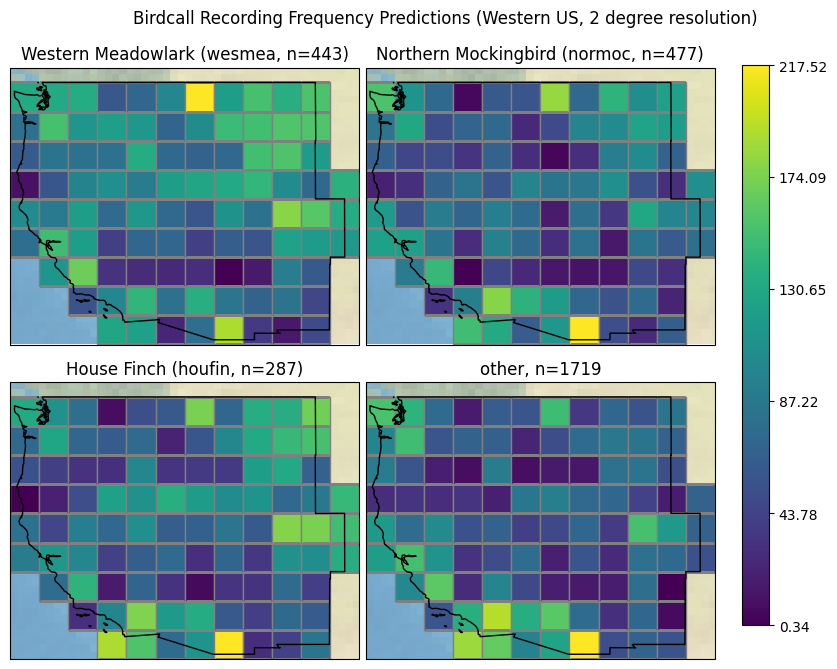

In [103]:
from birdcall_distribution.plot import plot_ppc_species_subplot

plot_ppc_species_subplot(
    prep_df,
    ppc1,
    species + ["other"],
    prop="pred",
    species_mapper=species_mapper,
    subtitle=f"Western US, {grid_size} degree resolution",
)
plt.show()

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

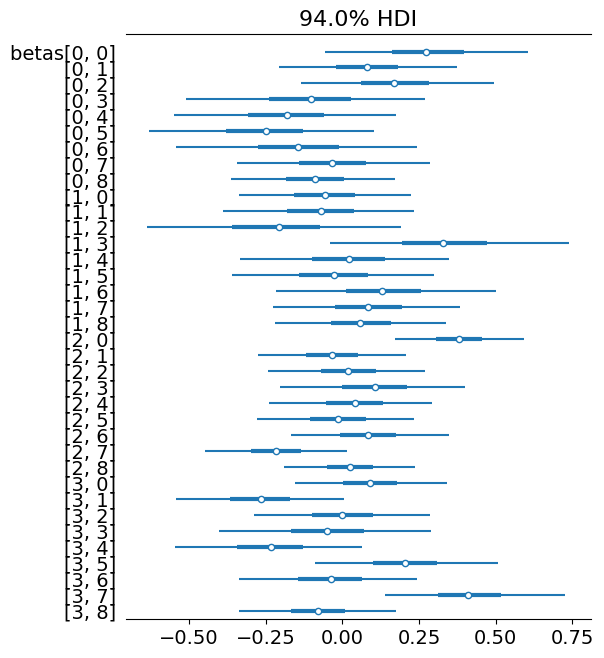

In [104]:
az.plot_forest(trace1, var_names=["betas"], combined=True)

In [106]:
betas = az.summary(trace1, var_names=["betas"])
betas

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",0.282,0.177,-0.055,0.607,0.008,0.006,457.0,1342.0,1.03
"betas[0, 1]",0.081,0.153,-0.205,0.375,0.004,0.003,1217.0,4816.0,1.01
"betas[0, 2]",0.176,0.168,-0.136,0.495,0.004,0.003,1976.0,4574.0,1.01
"betas[0, 3]",-0.109,0.207,-0.510,0.271,0.010,0.007,429.0,761.0,1.02
"betas[0, 4]",-0.188,0.193,-0.548,0.175,0.009,0.006,509.0,1126.0,1.03
"betas[0, 5]",-0.258,0.196,-0.631,0.105,0.014,0.010,200.0,654.0,1.05
"betas[0, 6]",-0.146,0.206,-0.543,0.242,0.011,0.008,340.0,655.0,1.04
"betas[0, 7]",-0.032,0.166,-0.342,0.286,0.008,0.005,481.0,1750.0,1.03
"betas[0, 8]",-0.091,0.143,-0.363,0.172,0.005,0.004,690.0,3066.0,1.02
"betas[1, 0]",-0.057,0.148,-0.335,0.224,0.012,0.009,143.0,493.0,1.07


In [109]:
from birdcall_distribution.model import _scaled_data

scaled_df = _scaled_data(prep_df)
scaled_df.columns

Index(['population_density', 'elevation_p50', 'LST_Day_1km_p95',
       'LST_Night_1km_p5', 'land_cover_07', 'land_cover_08', 'land_cover_09',
       'land_cover_10', 'land_cover_16'],
      dtype='object')

In [116]:
# find all betas where interval is entirely positive or negative
sig_betas = betas[
    ((betas["hdi_3%"] > 0) & (betas["hdi_97%"] > 0))
    | ((betas["hdi_3%"] < 0) & (betas["hdi_97%"] < 0))
]

In [121]:
prep_df.primary_label.astype("category").cat.categories

Index(['houfin', 'normoc', 'other', 'wesmea'], dtype='object')

In [131]:
sig_betas.reset_index()["index"]

0    betas[2, 0]
1    betas[3, 7]
Name: index, dtype: object

In [140]:
from birdcall_distribution.geo import get_modis_land_cover_name
import re


def maybe_landcover(name):
    try:
        return f"landcover {get_modis_land_cover_name(name)}".lower().replace(" ", "_")
    except Exception:
        return name


def replace_indices(name, species_list, covariate_list):
    # extract the indexes from the name e.g. [1, 2]
    [(species, covariate)] = list(re.findall(r"\[(\d+), (\d+)\]", name))
    species = species_list[int(species)]
    covariate = covariate_list[int(covariate)]
    return name.split("[")[0] + f"[{species}, {covariate}]"


species = prep_df.primary_label.astype("category").cat.categories
columns = [maybe_landcover(c) for c in scaled_df.columns]

sig_betas.index = sig_betas.reset_index()["index"].apply(
    lambda x: replace_indices(x, species, columns)
)
sig_betas

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
index,,,,,,,,,
"betas[other, population_density]",0.381,0.112,0.172,0.594,0.006,0.004,343.0,1734.0,1.03
"betas[wesmea, landcover_grasslands]",0.418,0.155,0.140,0.725,0.006,0.004,769.0,3805.0,1.02


In [151]:
print(sig_betas.iloc[:, :4].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &   mean &     sd &  hdi\_3\% &  hdi\_97\% \\
index                               &        &        &         &          \\
\midrule
betas[other, population\_density]    &  0.381 &  0.112 &   0.172 &    0.594 \\
betas[wesmea, landcover\_grasslands] &  0.418 &  0.155 &   0.140 &    0.725 \\
\bottomrule
\end{tabular}



C:\Users\acmiy\AppData\Local\Temp\ipykernel_20532\1226910382.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sig_betas.iloc[:,:4].to_latex())
